To see a full explanation of this notebook and gradient boosting in general, please refer to my page [here](https://lemonpy29.github.io/explained-ml/gradient-boosting.html)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt

seed = 1301

In [2]:
# modified version of the classic titanic data set from kaggle
# download at https://www.kaggle.com/heptapod/titanic
path = 'titanic_mod.csv'
data = pd.read_csv(path)

In [3]:
def split_data(data, target, drop, test_size=0.2, seed=seed):
    # short method to prepare and split
    data_wo_nan = data.dropna()
    flat_target = data_wo_nan[target].values.ravel()
    return train_test_split(data_wo_nan.drop(target + drop, axis=1),
                            flat_target,
                            test_size=test_size,
                            random_state=seed)

drop = ['Passengerid'] 
target = ['Survived']
X_train, X_test, y_train, y_test = split_data(data, target, drop)

In [4]:
base_learner = DecisionTreeClassifier(max_depth=3, random_state=seed)
base_learner.fit(X_train, y_train)
y_pred = base_learner.predict(X_test)

print(f"f1 score: {f1_score(y_test, y_pred):.2f}")

f1 score: 0.63


In [5]:
def binary_loss():
    def func(y, p): 
        return -2.0 * np.mean(y * np.log(p/(1-p)) - np.logaddexp(0.0, np.log(p/(1-p))))
    def gradient(y, p):
        return (p-y)/(p*(1-p))
    func.gradient = gradient
    return func

In [6]:
class gradient_booster:
    def __init__(self, loss, lr, **tree_config):
        self.lr = lr
        self.loss = loss 
        self.learners = [] 
        self.tree_config = tree_config
    
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    
    def _fit_base(self, X, y):
        base_learner = DecisionTreeClassifier(**self.tree_config, random_state=seed)
        base_learner.fit(X, y)
        self.learners.append(base_learner)
    
    def _predict_base(self, X):
        return self.learners[0].predict_proba(X)[:,1]
        
    def fit(self, X, y, boosting_rounds):
        self.loss_history = []
        self._fit_base(X, y)
        prbs = self._predict_base(X)
        predictions = prbs
        
        for _ in range(boosting_rounds):
            target = -self.loss.gradient(y, prbs)
            current_model = DecisionTreeRegressor(**self.tree_config, random_state=seed) 
            current_model.fit(X, target)
            self.learners.append(current_model)
            predictions += self.lr * current_model.predict(X)
            prbs = self.sigmoid(predictions) 
            self.loss_history.append(self.loss(y, prbs))
    
    def predict_proba(self, X):
        predictions = self._predict_base(X)
        for m in self.learners[1:]:
            predictions += self.lr * m.predict(X)
        return self.sigmoid(predictions)

In [7]:
booster = gradient_booster(loss=binary_loss(), lr=0.01, max_depth=3)

In [8]:
booster.fit(X_train, y_train, 50)

Text(0, 0.5, 'Binary Loss')

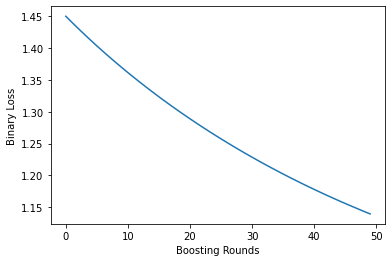

In [9]:
fig, ax = plt.subplots(1,1)
ax.plot(booster.loss_history)
ax.set_xlabel('Boosting Rounds')
ax.set_ylabel('Binary Loss')

In [10]:
y_prob = booster.predict_proba(X_test)
y_pred = 1*(y_prob>0.5)
print(f"f1 score: {f1_score(y_test,y_pred):.2f}")

f1 score: 0.71
